In [1]:
import torch
import torchvision
import torch.nn as nn

from PIL import Image
from torchvision import transforms
from torch.utils.data import random_split, DataLoader

import matplotlib.pyplot as plt

In [2]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.mps.is_available():
    device = torch.device('mps')

In [3]:
preprocess = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [4]:
dataset = torchvision.datasets.ImageFolder(
    root='../images/cropped_images_after_iva_seperated',
    transform=preprocess
)

In [5]:
torch.manual_seed(42)
train_dataset, val_dataset = random_split(dataset, [int(0.8 * len(dataset)), len(dataset) - int(0.8 * len(dataset))])
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [6]:
resnet50_model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)
for param in resnet50_model.parameters():
    param.requires_grad = False
resnet50_model.fc = nn.Identity()
resnet50_model.eval()
resnet50_model = resnet50_model.to(device)

In [7]:
fc_model = nn.Sequential(
    nn.Linear(2048, 1024),
    nn.ReLU(),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 1)
    
)
fc_model = fc_model.to(device)

In [8]:
model = nn.Sequential(
    resnet50_model,
    fc_model
)
model = model.to(device)

In [9]:
optimizer = torch.optim.Adam(fc_model.parameters(), lr=0.000025)
loss_fn = nn.BCEWithLogitsLoss()

In [10]:
train_losses = []
val_losses = []

for epoch in range(300):
    model.train()
    resnet50_model.eval()
    
    train_loss_sum = 0
    train_accurate = 0
    train_sum = 0
    for X, y in train_dataloader:
        X = X.to(device)
        y = y.to(device).type(torch.float32).reshape((-1, 1))
        
        outputs = model(X)
        optimizer.zero_grad()
        losses = loss_fn(outputs, y)
        train_loss_sum += losses.item()
        losses.backward()
        optimizer.step()
        
        prediction = torch.sigmoid(outputs) > 0.5 
        accurate = (y == prediction).sum().item()
        train_accurate += accurate
        train_sum += y.size(0)
    
    train_losses.append(train_loss_sum / len(train_dataloader))
    print(f'\nEpoch : {epoch}')
    print(f'Training Loss : {train_loss_sum / len(train_dataloader)}')
    print(f'Training Accuracy : {train_accurate / train_sum}')
    
    torch.save(fc_model.state_dict(), f'./model/fc_model_{epoch}.pth')
    
    model.eval()
    val_loss_sum = 0
    val_accurate = 0
    val_sum = 0
    with torch.no_grad():
        for X, y in val_dataloader:
            X = X.to(device)
            y = y.to(device).type(torch.float32).reshape((-1, 1))
            
            outputs = model(X)
            losses = loss_fn(outputs, y)
            val_loss_sum += losses.item()
            
            prediction = torch.sigmoid(outputs) > 0.5 
            accurate = (y == prediction).sum().item()
            val_accurate += accurate
            val_sum += y.size(0)
    
    val_losses.append(val_loss_sum / len(val_dataloader))
    print(f'Validation Loss : {val_loss_sum / len(val_dataloader)}')
    print(f'Validation Accuracy : {val_accurate / val_sum}')


Epoch : 0
Training Loss : 0.6940401792526245
Training Accuracy : 0.5
Validation Loss : 0.6908920109272003
Validation Accuracy : 0.5135135135135135

Epoch : 1
Training Loss : 0.6929494380950928
Training Accuracy : 0.5
Validation Loss : 0.6946795880794525
Validation Accuracy : 0.5135135135135135

Epoch : 2
Training Loss : 0.6921586871147156
Training Accuracy : 0.5
Validation Loss : 0.693815678358078
Validation Accuracy : 0.5135135135135135

Epoch : 3
Training Loss : 0.6899185061454773
Training Accuracy : 0.5
Validation Loss : 0.6919369399547577
Validation Accuracy : 0.5135135135135135

Epoch : 4
Training Loss : 0.6893726110458374
Training Accuracy : 0.5067567567567568
Validation Loss : 0.6919645965099335
Validation Accuracy : 0.5135135135135135

Epoch : 5
Training Loss : 0.6872297167778015
Training Accuracy : 0.5405405405405406
Validation Loss : 0.6868894398212433
Validation Accuracy : 0.5405405405405406

Epoch : 6
Training Loss : 0.6873415589332581
Training Accuracy : 0.547297297297297

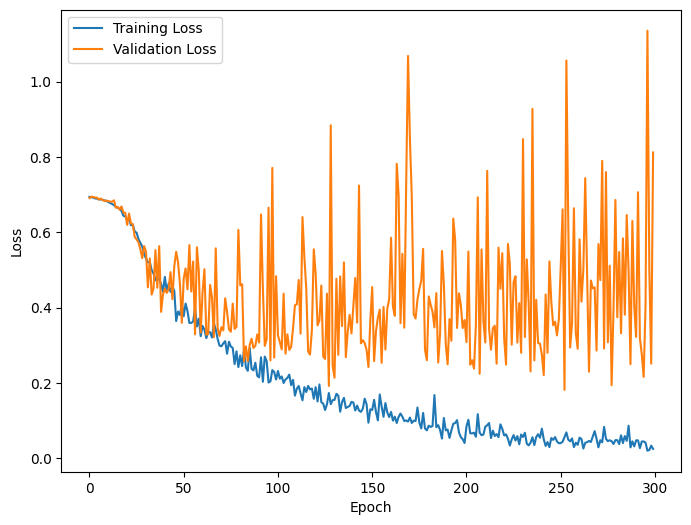

In [11]:
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()